此处花了一个晚上才搞明白为什么画出来的图和教授的不一样： 因为获取数据的时候应该是2016 - 2022年的但是读取数据的时候搞成自上到下为2022-2016的
所以return自然全算反了注意算return之前先按时间把价钱数据框按时间进行排序price_df = price_df.sort_values(by='Date')


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from scipy.optimize import minimize
from cvxpy import *

In [2]:
#(1)
# Get data
def get_data(start_date, end_date):
    # Define the start and end dates of stock prices
    start_date = dt.datetime(start_date, 1, 1)
    end_date = dt.datetime(end_date, 9, 1)

    # download data
    source = "stooq"
    etf1 = web.DataReader('GM', source, start_date, end_date)
    etf2 = web.DataReader('MSFT', source, start_date, end_date)
    etf3 = web.DataReader('NFLX', source, start_date, end_date)
    etf4 = web.DataReader('KO', source, start_date, end_date)
    etf5 = web.DataReader('AAPL', source, start_date, end_date)
    etf6 = web.DataReader('AMZN', source, start_date, end_date)
    data_joined = [etf1["Close"], etf2["Close"], etf3["Close"],etf4["Close"],etf5["Close"],etf6["Close"]]
    price_df = pd.concat(data_joined, axis=1)
    #price_df.columns = [names[0],names[1],names[2]]
    price_df = price_df.sort_values(by='Date')
    return_df = price_df.pct_change(1).dropna()
    return return_df
return_df = get_data(2016, 2022)

In [4]:
return_df.columns = ["GM","MSFT","NFLX","KO","AAPL","AMZN"]
return_df

,GM,MSFT,NFLX,KO,AAPL,AMZN
Date,,,,,,
2016-01-05,-0.026390,0.004526,-0.020917,0.003523,-0.025216,-0.005024
2016-01-06,-0.035722,-0.018142,0.093071,-0.005496,-0.019553,-0.001799
2016-01-07,-0.040920,-0.034769,-0.026513,-0.016407,-0.042216,-0.039058
2016-01-08,-0.015394,0.003015,-0.027671,-0.002590,0.005237,-0.001464
2016-01-11,0.024324,-0.000570,0.032139,0.001592,0.016264,0.017610
...,...,...,...,...,...,...
2022-08-26,-0.028721,-0.038587,-0.045730,-0.024122,-0.037699,-0.047567
2022-08-29,0.007138,-0.010668,0.005777,-0.006021,-0.013690,-0.007342
2022-08-30,-0.007357,-0.008521,-0.017456,-0.009246,-0.015305,-0.008167


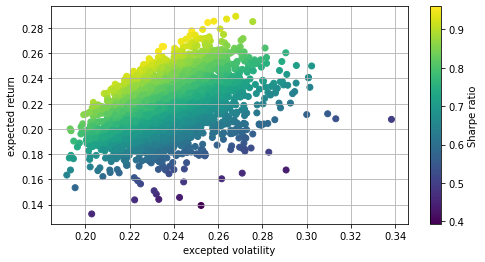

In [5]:
#(2)
# 蒙特卡洛模拟
port_returns = []
port_variance = []
stock_num = len(return_df.columns)
for p in range(3000):
    weights = np.random.random(stock_num)
    weights /= np.sum(weights)
    #计算portfolio的均值
    port_returns.append(np.sum(return_df.mean()*weights) * 252)
    #计算portfolio的方差
    port_variance.append(np.sqrt(252)*np.sqrt(np.dot(weights.T, np.dot(return_df.cov(), weights))))

port_returns = np.array(port_returns)
port_variance = np.array(port_variance)

# 无风险利率设定为4%

risk_free = 0.04
plt.figure(figsize = (8,4))
plt.scatter(port_variance, port_returns, c=(port_returns-risk_free)/port_variance, marker = 'o')
plt.grid(True)
plt.xlabel('excepted volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')


In [7]:
# (3)
# 投资组合优化1——sharpe最大

def statistics(weights):
    port_returns = np.sum(return_df.mean()*weights)*252
    port_var = np.sqrt(np.dot(weights.T, np.dot(return_df.cov()*252, weights)))
    return port_returns, port_var, port_returns/port_var

#最优化投资组合的推导是一个约束最优化问题
import scipy.optimize as sco
def min_sharpe(weights):
    return -statistics(weights)[2]

#约束是所有参数(权重)的总和为1 并且最小值为0，因为我们不做空股票。这可以用minimize函数的约定表达如下
cons = ({'type':'eq', 'fun':lambda x: np.sum(x)-1},{'type':'ineq','fun':lambda x:x - 0})
#我们还将参数值(权重)限制在0和1之间。这些值以多个元组组成的一个元组形式提供给最小化函数
#bnds = tuple((0,1) for x in range(stock_num))
opts = sco.minimize(min_sharpe, stock_num*[1./stock_num], method = 'SLSQP', constraints = cons)
opts["x"].round(3)#查看weight比重
print("weight:\n", opts["x"].round(3))
statistics(opts["x"].round(3))#输出sharp ratio最大的时候的portfolio的 均值；方差；夏普比率
print("mean; vol; sharp ratio:\n", statistics(opts["x"].round(3)))

weight:
 [0.    0.383 0.    0.085 0.505 0.027]
mean; vol; sharp ratio:
 (0.29151203233926276, 0.2520602424500551, 1.1565173051716988)


In [8]:
#(3.1)
# 投资组合优化1——vol最小
def statistics(weights):
    port_returns = np.sum(return_df.mean()*weights)*252
    port_var = np.sqrt(np.dot(weights.T, np.dot(return_df.cov()*252, weights)))
    return port_returns, port_var, port_returns/port_var

#最优化投资组合的推导是一个约束最优化问题
import scipy.optimize as sco
def min_variance(weights):
    return statistics(weights)[1]

optv = sco.minimize(min_variance, stock_num*[1./stock_num],method = 'SLSQP', constraints = cons)
optv["x"].round(3)
print("weight:\n", optv["x"].round(3))
print("mean; vol; sharp ratio:\n", statistics(optv["x"].round(3)))

weight:
 [0.039 0.    0.043 0.74  0.042 0.136]
mean; vol; sharp ratio:
 (0.142410259959171, 0.17888248180461783, 0.7961107120300178)


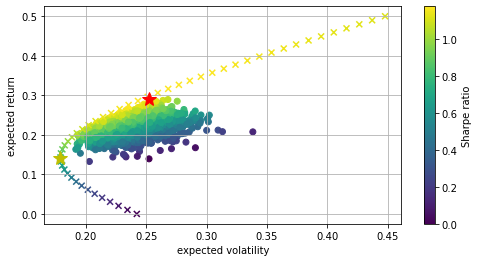

In [9]:

#(4)组合的有效前沿
def min_variance(weights):
    return statistics(weights)[1]

target_returns = np.linspace(0,0.5,50)
target_variance = []
for tar in target_returns:
    cons = ({'type':'eq','fun':lambda x:statistics(x)[0]-tar},{'type':'eq','fun':lambda x:np.sum(x)-1})
    res = sco.minimize(min_variance, stock_num*[1./stock_num],method = 'SLSQP', constraints = cons)
    target_variance.append(res['fun'])#res["fun"]就是函数最小的返回值

target_variance = np.array(target_variance)


plt.figure(figsize = (8,4))
#圆圈：蒙特卡洛随机产生的组合分布
plt.scatter(port_variance, port_returns, c = port_returns/port_variance,marker = 'o')
#叉号：有效前沿
plt.scatter(target_variance,target_returns, c = target_returns/target_variance, marker = 'x')
#红星：标记最高sharpe组合
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize = 15.0)
#黄星：标记最小方差组合
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize = 15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe ratio')